In [1]:
from model import Model
from earlystop import EarlyStopper
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## **Data Preparation**

In [2]:
# Read in data
img_size = 128 # original 768x768 caused memory issues, 128x128 too small
data_transformation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [3]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [4]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 3750, 3750)

In [5]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = img / 2 + 0.5     # Unnormalize.
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0))) # Convert to (H,W,C)
    ax.set_title(classes[label])
    ax.axis('off')

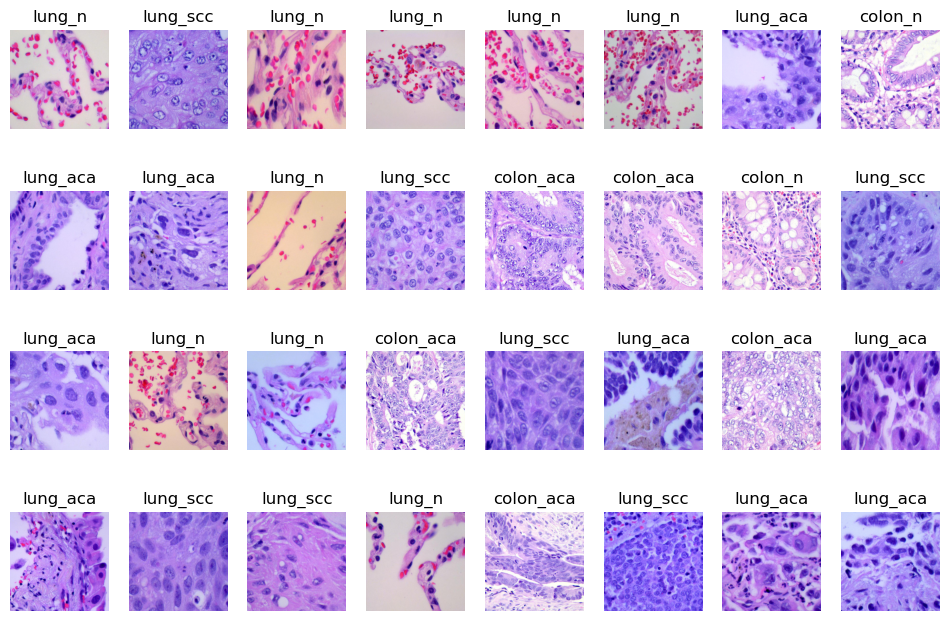

In [6]:
plt.figure(figsize=(12, 8))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)  

mps


## **Set Up Training, Validation, and Testing Steps**

In [8]:
def trainNN(network, train_loader, loss_function, optimizer, print_freq=50):
    network.train()  # Set the network to training mode
    mini_batch_loss = 0.0 # Initialize running loss within epoch
    total_loss = 0.0 # Initialize running loss for whole epoch
    total_batches = 0 

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the specified device
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = network(inputs)  # Forward pass
        loss = loss_function(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        # Track losses
        mini_batch_loss += loss.item()
        total_loss += loss.item()
        total_batches += 1

        # Print average loss for every 'print_freq' mini-batches
        if i % print_freq == print_freq - 1:
            print(f'Mini-batch (i: {i+1}): Average mini-batch loss: {mini_batch_loss / print_freq:.3f}')
            mini_batch_loss = 0.0

    avg_train_loss = total_loss / total_batches
    return avg_train_loss


In [9]:
def validateNN(network, valid_loader, loss_function):
    network.eval() # Set the network to evaluation mode
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():  # No gradients needed for validation
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to the specified device
            outputs = network(inputs)  # Forward step
            loss = loss_function(outputs, labels)  # Calculate loss

            total_loss += loss.item() 
            total_batches += 1
    
    avg_valid_loss = total_loss / total_batches
    return avg_valid_loss

In [10]:
def train_and_validateNN(network, train_loader, valid_loader, loss_function, optimizer, epochs, print_freq=50, early_stopper=None):
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print(f'[Epoch {epoch+1}/{epochs}]')

        # Train for one epoch
        avg_train_loss = trainNN(network, train_loader, loss_function, optimizer, print_freq)
        train_losses.append(avg_train_loss)

        # Validate after training
        avg_valid_loss = validateNN(network, valid_loader, loss_function)
        valid_losses.append(avg_valid_loss)

        print(f'End of Epoch {epoch+1} - train loss: {avg_train_loss:.4f}, valid loss: {avg_valid_loss:.4f}')

        # Early Stopping Check
        if early_stopper and early_stopper.stop(avg_valid_loss):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    print('Finished Training.')
    return train_losses, valid_losses


In [11]:
def testNN(network, test_loader, classes):
    network.eval()  # Set the network to evaluation mode
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():  # No gradients needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = network(images) # Forward
            
            _, predicted = torch.max(outputs, 1) # Get the predictions from the maximum value
            correct = (predicted == labels).squeeze() # Compare predictions with the true label
            
            # Update lists 
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # Calculate accuracies
    class_accuracies = {}
    for i, class_name in enumerate(classes):
        class_accuracy = (class_correct[i] / class_total[i])*100
        class_accuracies[class_name] = class_accuracy
    overall_accuracy = (sum(class_correct) / sum(class_total))*100

    # Print accuracy for each class using the classes names
    for i in range(len(classes)):
        print(f'Accuracy for {classes[i]}: {(class_correct[i]/class_total[i])*100:.1f}%')
    print(f'Overall Model Accuracy: {sum(class_correct)/sum(class_total)*100:.1f}%')
    return class_accuracies, overall_accuracy


### ReLU + MaxPool

In [12]:
relu_MaxPool_CNN = Model('relu', 'max', img_size, elu_val = 1, lrelu_val = 0.01)
relu_MaxPool_CNN.to(device)

Model(
  (layers): Sequential(
    (0): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvBlock(
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), p

In [13]:
early_stopper = EarlyStopper(patience=2, min_delta=3)



relu_MaxPool_train_loss, relu_MaxPool_valid_loss = train_and_validateNN(relu_MaxPool_CNN, train_loader, valid_loader, nn.CrossEntropyLoss(),
                                                                      optim.Adam(relu_MaxPool_CNN.parameters(), lr=0.001), 5, print_freq=100,
                                                                      early_stopper=early_stopper)

[Epoch 1/5]
Mini-batch (i: 100): Average mini-batch loss: 0.477
Mini-batch (i: 200): Average mini-batch loss: 0.355
Mini-batch (i: 300): Average mini-batch loss: 0.282
Mini-batch (i: 400): Average mini-batch loss: 0.277
Mini-batch (i: 500): Average mini-batch loss: 0.272
End of Epoch 1 - train loss: 0.3217, valid loss: 2.6155
[Epoch 2/5]
Mini-batch (i: 100): Average mini-batch loss: 0.213
Mini-batch (i: 200): Average mini-batch loss: 0.238
Mini-batch (i: 300): Average mini-batch loss: 0.191
Mini-batch (i: 400): Average mini-batch loss: 0.180
Mini-batch (i: 500): Average mini-batch loss: 0.170
End of Epoch 2 - train loss: 0.2000, valid loss: 4.6253
[Epoch 3/5]
Mini-batch (i: 100): Average mini-batch loss: 0.180
Mini-batch (i: 200): Average mini-batch loss: 0.173
Mini-batch (i: 300): Average mini-batch loss: 0.176
Mini-batch (i: 400): Average mini-batch loss: 0.169
Mini-batch (i: 500): Average mini-batch loss: 0.126
End of Epoch 3 - train loss: 0.1611, valid loss: 7.5279
[Epoch 4/5]
Mini

In [46]:
# plt.figure(figsize=(8,6))
# plt.style.use('seaborn-v0_8')
# plt.plot(reluMaxPool_train_loss, 'red', label = 'Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Average Epoch Loss')
# plt.title('Training and Validation Loss by Epoch')
# plt.legend()
# plt.show()

In [47]:
# plt.figure(figsize=(8,6))
# plt.style.use('seaborn-v0_8')
# plt.plot(reluMaxPool_valid_loss, 'green', label = 'Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Average Epoch Loss')
# plt.title('Training and Validation Loss by Epoch')
# plt.legend()
# plt.show()

### ReLU + AvgPool

### LeakyReLU + MaxPool

### LeakyReLU + AvgPool

### ELU + MaxPool

### ELU + AvgPool

## **Evaluate on Testing Data**

In [14]:
_ , _ = testNN(relu_MaxPool_CNN, test_loader, classes) # used 480x480, doesn't seems to be improving

Accuracy for colon_aca: 0.0%
Accuracy for colon_n: 0.0%
Accuracy for lung_aca: 0.0%
Accuracy for lung_n: 0.0%
Accuracy for lung_scc: 100.0%
Overall Model Accuracy: 19.9%


## **Comparison to other popular CNN Architectures**

Any other popular architectures (feel free to edit / we can decide together)